# Latent Dirichlet Allocation (LDA)

Reference codes: \
https://alvinntnu.github.io/NTNU_ENC2045_LECTURES/nlp/topic-modeling-naive.html \
https://shravan-kuchkula.github.io/topic-modeling/#data-gathering-and-normalization \
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

### Packages

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib_venn import venn3
from sklearn.decomposition import LatentDirichletAllocation

## Load metadata

In [17]:
md = pd.read_csv('mt_country/call_tpf.csv')

dpi = 300
code = 'JPN' , 'KOR', 'SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL'
year = '2014', '2015', '2016', '2017' ,'2018', '2019', '2020', '2021'

tcolor = ['#AEC7E8', '#1F77B4', '#FFBB78', '#FF7F0E', 
           '#98DF8A', '#2CA02C', '#FF9896', '#D62728',
           '#C5B0D5', '#9467BD', '#C49C94', '#8C564B', 
           '#DBDB8D', '#BCBD22', '#C7C7C7', '#7F7F7F']

hsl_color = ['214, 56%, 80%', '205, 71%, 41%', '30, 100%, 74%', '28, 100%, 53%', 
             '110, 57%, 71%', '120, 57%, 40%', '1, 100%, 79%', '0, 69%, 50%',
             '274, 31%, 76%', '271, 39%, 57%', '10, 29%, 68%', '10, 30%, 42%',
             '60, 52%, 71%', '60, 70%, 44%', '0, 0%, 78%', '0, 0%, 50%']

tcode = ['T1-RNA and transcription', 'T2-Epigenetics and \n epigenomics', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Population genomics', 
                'T9-Microbial community', 'T10-Translational medicine', 'T11-Disease mechanisms', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-Metabolic pathways', 'T14-Mitochondrial and \n viral genomes', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

K = ['T'+ str(n) for n in list(range(1,16+1))]
ddcolor = {K[i]: tcolor[i] for i in range(len(K))}

In [3]:
mdt = md['Clean Abstract']

In [5]:
md.loc[9221, 'Abstract']

"The hookworm Necator americanus is the predominant soil-transmitted human parasite. Adult worms feed on blood in the small intestine, causing iron-deficiency anemia, malnutrition, growth and development stunting in children, and severe morbidity and mortality during pregnancy in women. We report sequencing and assembly of the N. americanus genome (244 Mb, 19,151 genes). Characterization of this first hookworm genome sequence identified genes orchestrating the hookworm's invasion of the human host, genes involved in blood feeding and development, and genes encoding proteins that represent new potential drug targets against hookworms. N. americanus has undergone a considerable and unique expansion of immunomodulator proteins, some of which we highlight as potential treatments against inflammatory diseases. We also used a protein microarray to demonstrate a postgenomic application of the hookworm genome sequence. This genome provides an invaluable resource to boost ongoing efforts toward

In [ ]:
#foo = md[(md['JPN']==True) & (md['KOR']==True) & (md['SGP']==False) & (md['THA']==False) &
#           (md['MYS']==False) & (md['VNM']==False) & (md['IDN']==False) & (md['PHL']==True)]
#foo['Title']

### Construct index (opt)

In [4]:
all_idx = np.argwhere(np.array(md['Year'].astype(str).str.contains('20'))).T[0]
idn_idx = np.argwhere(np.array(md['IDN'])).T[0]
jpn_idx = np.argwhere(np.array(md['JPN'])).T[0]
kor_idx = np.argwhere(np.array(md['KOR'])).T[0]
sig_idx = np.argwhere(np.array(md['SGP'])).T[0]
phi_idx = np.argwhere(np.array(md['PHL'])).T[0]
mal_idx = np.argwhere(np.array(md['MYS'])).T[0]
tha_idx = np.argwhere(np.array(md['THA'])).T[0]
vie_idx = np.argwhere(np.array(md['VNM'])).T[0]
dd_idx = np.argwhere(np.array(md['JPN'] | md['KOR'])).T[0]
dm_idx = np.argwhere(np.array(md['SGP'] | md['THA'] | md['MYS'])).T[0]
dg_idx = np.argwhere(np.array(md['VNM'] | md['IDN'] | md['PHL'])).T[0]

em_idx = np.argwhere(np.array(md['2014'])).T[0]
li_idx = np.argwhere(np.array(md['2015'])).T[0]
en_idx = np.argwhere(np.array(md['2016'])).T[0]
tu_idx = np.argwhere(np.array(md['2017'])).T[0]
de_idx = np.argwhere(np.array(md['2018'])).T[0]
se_idx = np.argwhere(np.array(md['2019'])).T[0]
du_idx = np.argwhere(np.array(md['2020'])).T[0]
sa_idx = np.argwhere(np.array(md['2021'])).T[0]

idx = [jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx, phi_idx]
idx2 = [all_idx, jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx, phi_idx]

## Word vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def tfidf_generator (corpus = '', no_features = '', min_df = ''):
    tv = TfidfVectorizer(max_df=0.5, min_df=min_df, max_features=no_features, token_pattern=r'\S+')
    tt = tv.fit_transform(corpus)
    cv = CountVectorizer(max_df=0.5, min_df=min_df, max_features=no_features, token_pattern=r'\S+')
    ct = cv.fit_transform(corpus)
    print (tt.shape, ct.shape)
    return tv, tt, cv, ct 

def wdf_generator(tv = '', tt = '', ct = ''):
    tt_t = tt.transpose()
    dt = tt.sum(axis=0).transpose().tolist()
    dc = ct.sum(axis=0).transpose().tolist()
    dn = [line.nnz for line in tt_t]
    dw = tv.get_feature_names()

    dft = pd.DataFrame(dt, columns = ['tf-idf'])
    dfc = pd.DataFrame(dc, columns = ['word count'])
    dfd = pd.DataFrame(dn, columns = ['document count'])
    dfw = pd.DataFrame(dw, columns = ['word'])

    df = pd.concat([dfw, dft, dfc, dfd],axis=1)
    df['tf-idf norm'] = (df['tf-idf']/df['tf-idf'].sum())*100
    df['word count norm'] = (df['word count']/df['word count'].sum())*100
    df['document count norm'] = (df['document count']/df['document count'].sum())*100
    print (len(df))
    return df

def visualize_df (dff = '', top_words = ''):
    dft = dff.sort_values(by = 'tf-idf', ascending = True, ignore_index = True).tail(top_words)
    dfd = dff.sort_values(by = 'document count', ascending = True, ignore_index = True).tail(top_words)
    dfc = dff.sort_values(by = 'word count', ascending = True, ignore_index = True).tail(top_words)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=False, figsize=(8,6))
    ax1.barh(width = dft['tf-idf'], y= dft['word'])
    ax1.set_title('Cumulative tf-idf', size =13)
    ax1.set_xlabel('Tf-idf value', size =12)

    ax2.barh(width = dfc['word count'], y= dfc['word'])
    ax2.set_title('Word count', size =13)
    #plt.xticks(rotation=90, size=18); plt.yticks(size=14)
    ax2.set_xlabel('Count', size =12)

    ax3.barh(width = dfd['document count'], y= dfd['word'])
    ax3.set_title('Word frequency', size =13)
    #plt.xticks(rotation=90, size=18); plt.yticks(size=14)
    ax3.set_xlabel('Document', size =12)
    plt.tight_layout()
#    plt.savefig('fig/lda/wordbar.png', dpi=dpi)
    plt.show()

In [6]:
tv, tt, cv, ct = tfidf_generator(mdt, None, 2)
df = wdf_generator(tv, tt, ct)
#visualize_df(df, 50)

(21308, 33568) (21308, 33568)


/home/nailil/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


33568


## Remove genetic word

In [7]:
comm_gen_word = ['gene', 'mutation', 'mutational', 
                 'sequence', 'sequenced', 'sequencer', 'sequencing', 'sequential',
                 'genom', 'genome', 'genomic', 'genomics', 
                 'genetic', 'geneticist', 'genetics']

mdc = md[['Source title', 'Clean Abstract']]
mdc['Filtered Abstact'] = md['Clean Abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (comm_gen_word)]))
#mdc.to_csv('mt_country/call_tpfa.csv', index = False)
mdcf = mdc['Filtered Abstact']

/tmp/ipykernel_3286/1893865994.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdc['Filtered Abstact'] = md['Clean Abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (comm_gen_word)]))


(21308, 33554) (21308, 33554)
33554


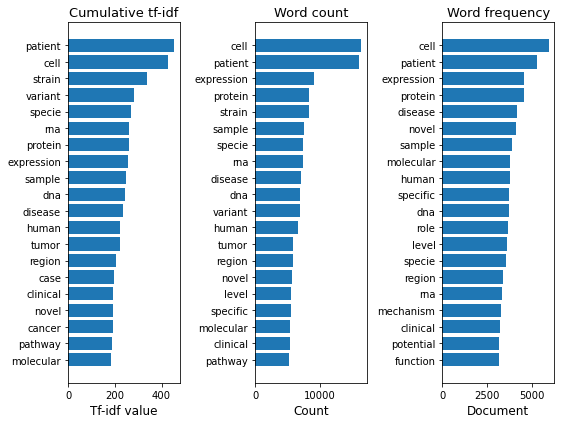

In [8]:
tv, tt, cv, ct = tfidf_generator(mdcf, None, 2)
df = wdf_generator(tv, tt, ct)
visualize_df(df, 20)

In [11]:
fn = tv.get_feature_names()
fnn = [line for line in fn if line.startswith('personali')]
fnn

['personalised', 'personality', 'personalized']

## Check sparsity

In [79]:
# Materialize the sparse data
%time data_dense = tt.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

CPU times: user 480 ms, sys: 960 ms, total: 1.44 s
Wall time: 1.44 s
Sparsicity:  0.15941278967669367 %


## Visualize word count

In [12]:
vw_count = [line.nnz for line in tt]
md['va_count'] = vw_count

dfc = pd.DataFrame({'Original \n abstract': md['abs_count'], 
                    'Processed \n word': md['fa_count'], 
                    'Vectorized \n word': vw_count})

fig, ax = plt.subplots(figsize = (4,4))
sns.boxplot(data= dfc, ax=ax, palette = "tab10")
plt.ylabel('Word count', size=12)
plt.tight_layout()
#plt.savefig('fig/lda/bxlda.png', dpi=dpi)
plt.show()

<Figure size 400x400 with 1 Axes>

<ipython-input-23-c68e560534b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf2['Word \n Vectorization'] = vw_count


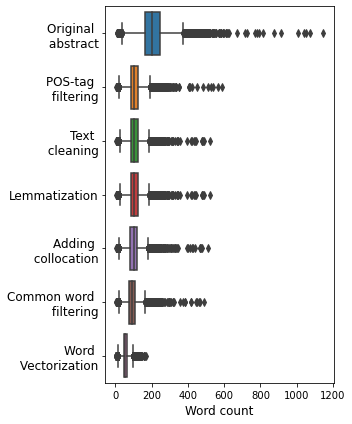

In [23]:
bdf2 = md[['abs_count', 'pa_count', 'ca_count', 'ca_count', 'ga_count', 'fa_count']]
bdf2.columns = ['Original \n abstract', 'POS-tag \n filtering', 'Text \n cleaning', 
                'Lemmatization', 'Adding \n collocation', 'Common word \n filtering']
bdf2['Word \n Vectorization'] = vw_count

fig, ax = plt.subplots(figsize = (5,6))
sns.boxplot(data= bdf2, orient="h", ax=ax, palette = "tab10")
plt.xlabel('Word count', size=12)
plt.yticks(size=12)
plt.tight_layout()
#plt.savefig('fig/lda/pabpvh.png', dpi=dpi)
plt.show()

In [11]:
bdf2.sort_values(by = 'Word \n Vectorization').head(5)

,Original \n abstract,POS-tag \n filtering,Text \n cleaning,Tokeni- and \n lemmatization,Adding \n collocation,Common word \n filtering,Word \n Vectorization
707,10,4,2,2,2,2,2
705,20,13,10,10,10,8,3
10918,14,10,7,7,7,5,5
5910,16,13,8,8,8,6,5
18564,12,13,7,7,7,7,5


In [12]:
import nltk
from nltk.tokenize import word_tokenize

tpsim = md.loc[4541, ['Abstract', 'PA', 'PA', 'CA', 'GA', 'FA', 'FA']]
dtp = pd.DataFrame(tpsim).transpose()
dtp.columns = ['Original abstract', 'POS-tag filtering', 'Text cleaning', 
                'Lemmatization', 'Adding collocation', 'Common word filtering', 'Word Vectorization']
dtp.transpose().to_excel('tp_example.xlsx')
dtp.transpose()

,4541
Original abstract,"Here, we report the complete genome sequence o..."
POS-tag filtering,complete genome sequence Adlercreutzia sp stra...
Text cleaning,complete genome sequence Adlercreutzia sp stra...
Lemmatization,complete genome sequence adlercreutzia strain ...
Adding collocation,complete_genome_sequence adlercreutzia strain ...
Common word filtering,complete_genome_sequence adlercreutzia strain ...
Word Vectorization,complete_genome_sequence adlercreutzia strain ...


## Evaluate perplexity and log-likelihood

In [13]:
perplexity = []
score = []
K = range(2,31)
for k in K:
    lda = LatentDirichletAllocation(n_components=k, learning_method='online', max_iter=5, random_state=10)
    lda_f = lda.fit(ct)
    lda_p = lda.perplexity(ct)
    lda_s = lda.score(ct)
    perplexity.append(lda_p)
    score.append(lda_s)
    print (k)

per_n = [float(i)/sum(perplexity) for i in perplexity]
sco_n = [float(i)/sum(score) for i in score]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


## Evaluate coherence score

In [14]:
import tmtoolkit
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
def topic_model_coherence_generator(num_topics = '',
                                    norm_corpus='',
                                    cv_matrix='',
                                    cv=''):
    norm_corpus_tokens = [doc.split() for doc in norm_corpus]
    models = []
    coherence_scores = []

    for i in num_topics:
        cur_lda = LatentDirichletAllocation(n_components=i,
                                            learning_method='online',
                                            max_iter=5,
                                            random_state=10)
        cur_lda.fit_transform(cv_matrix)
        cur_coherence_score = metric_coherence_gensim(
            measure='c_v',
            top_n=20,
            topic_word_distrib=cur_lda.components_,
            dtm=cv.fit_transform(norm_corpus),
            vocab=np.array(cv.get_feature_names()),
            texts=norm_corpus_tokens)
        models.append(cur_lda)
        coherence_scores.append(np.mean(cur_coherence_score))
        print(i)
    return models, coherence_scores

In [15]:
K = range(2,31)
models, coherence_scores = topic_model_coherence_generator(
    num_topics=K, norm_corpus=mdcf, cv=cv, cv_matrix=ct)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<function matplotlib.pyplot.show(close=None, block=None)>

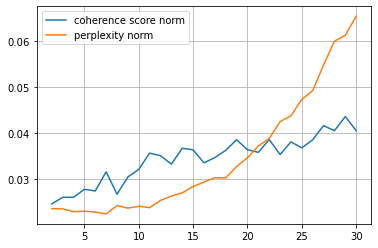

In [16]:
coh_n = [float(i)/sum(coherence_scores) for i in coherence_scores]

edf = pd.DataFrame({
    'topic_number': K,
    'coherence_score': coherence_scores, 'coh_n' : coh_n,
    'perplexity': perplexity, 'per_n' : per_n,
    'log_likelihood' : score, 'sco_n' : sco_n})

#edf.to_csv('fig/lda/ldaev2.csv')
ax = plt.gca()
plt.plot(edf['topic_number'], edf['coh_n'], label='coherence score norm')
plt.plot(edf['topic_number'], edf['per_n'], label='perplexity norm')
plt.grid(True); plt.legend()
#plt.savefig('fig/lda/evline2.png', dpi=dpi)
plt.show
#edf

In [13]:
edf =pd.read_csv('fig/lda/ldaev2.csv')

edf.sort_values(by = 'coherence_score').tail(8)

,Unnamed: 0,topic_number,coherence_score,coh_n,perplexity,per_n,log_likelihood,sco_n
21,21,23,0.576507,0.035846,2823.284291,0.033045,-1.444155e+07,0.034307
3,3,5,0.576777,0.035863,3036.784606,0.035544,-1.457404e+07,0.034622
6,6,8,0.582125,0.036196,2929.093037,0.034284,-1.450842e+07,0.034466
10,10,12,0.582643,0.036228,2890.405817,0.033831,-1.448425e+07,0.034409
17,17,19,0.585060,0.036378,2816.288498,0.032963,-1.443704e+07,0.034297
24,24,26,0.586984,0.036498,2786.847842,0.032619,-1.441794e+07,0.034251
14,14,16,0.589504,0.036655,2857.927372,0.033451,-1.446371e+07,0.034360
18,18,20,0.590148,0.036695,2798.447936,0.032754,-1.442549e+07,0.034269


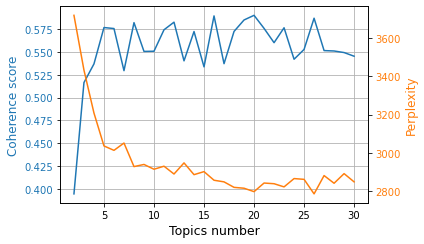

In [14]:
# Create some mock data
fig, ax1 = plt.subplots(figsize = (6,3.5))

color = 'tab:blue'
ax1.set_xlabel('Topics number', size = 12.5)
ax1.set_ylabel('Coherence score', color=color,size = 12)
ax1.plot(edf['topic_number'], edf['coherence_score'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Perplexity', color=color, size = 12)  # we already handled the x-label with ax1
ax2.plot(edf['topic_number'], edf['perplexity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(True, 'both')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('fig/lda/evlinew.png', dpi=dpi)
plt.show()

## GridSearch the best LDA model

In [17]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [2, 5, 10, 15, 25], 'learning_decay': [.5, .7, .9]}

# Init the model
lda = LatentDirichletAllocation()

# Init Grid Search class
model = GridSearchCV(lda, search_params)

model.fit(tf)
best_lda_model = model.best_estimator_
print("Best model's params: ", model.best_params_)
print("Best log likelihood score: ", model.best_score_)
print("Model perplexity: ", best_lda_model.perplexity(tf))

Best model's params:  {'learning_decay': 0.9, 'n_components': 2}
Best log likelihood score:  -75196.97071748643
Model perplexity:  1456.3317755095109


## LDA

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

no_topics = 16
# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, learning_method='online', max_iter=5, random_state=10)
lda_f = lda.fit(ct)
lda_ft = lda.fit_transform(ct)
lda_ft.shape

import pyLDAvis.sklearn
panel = pyLDAvis.sklearn.prepare(lda, ct, cv, mds='pcoa', sort_topics=False)
#pyLDAvis.save_html(panel, 'fig/lda/ldaf'+str(no_topics)+'.html')
pyLDAvis.display(panel)

/home/nailil/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Topic word

In [16]:
K = ['T'+ str(n) for n in list(range(1,no_topics+1))]
dfi = md[['JPN', 'KOR', 'SGP', 'THA', 'MYS', 'VNM', 'IDN', 'PHL', 
          '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']]
doc_topic_df = pd.DataFrame(lda_ft, columns=K)
#doc_topic_df['Year'] = md['Year'].tolist()
topic_word_matrix = lda.components_
vocab = cv.get_feature_names()
word_topic_df = pd.DataFrame(np.transpose(topic_word_matrix), index=vocab, columns=K)

/home/nailil/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [346]:
# prepare input for visualiz, observ

tcode = ['T1-RNA and transcription', 'T2-Epigenetics and \n epigenomics', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Population genomics', 
                'T9-Microbial community', 'T10-Translational medicine', 'T11-Disease mechanisms', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-Metabolic pathways', 'T14-Viral and Mitochondrial genomes', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

df_visuliz = pd.concat([dfi,doc_topic_df], axis=1)
#df_visuliz.to_csv('fig/lda/ldaoutr.csv', index=False)

df_observ = pd.concat([dfi,doc_topic_df], axis=1)
df_observ['Year'] = md['Year'].tolist()
#df_observ.to_csv('fig/lda/ldaouty.csv', index=False)


In [14]:
#Prepare input for data mining

mmm = pd.read_csv('fig/lda/ldaoutrn.csv')
#falist = mdc['Filtered Abstact'].tolist()
mmm['Filtered Abstact'] = falist
#mmm.to_csv('fig/lda_n/lda_dm.csv', index=False)

### Generate wordcloud 

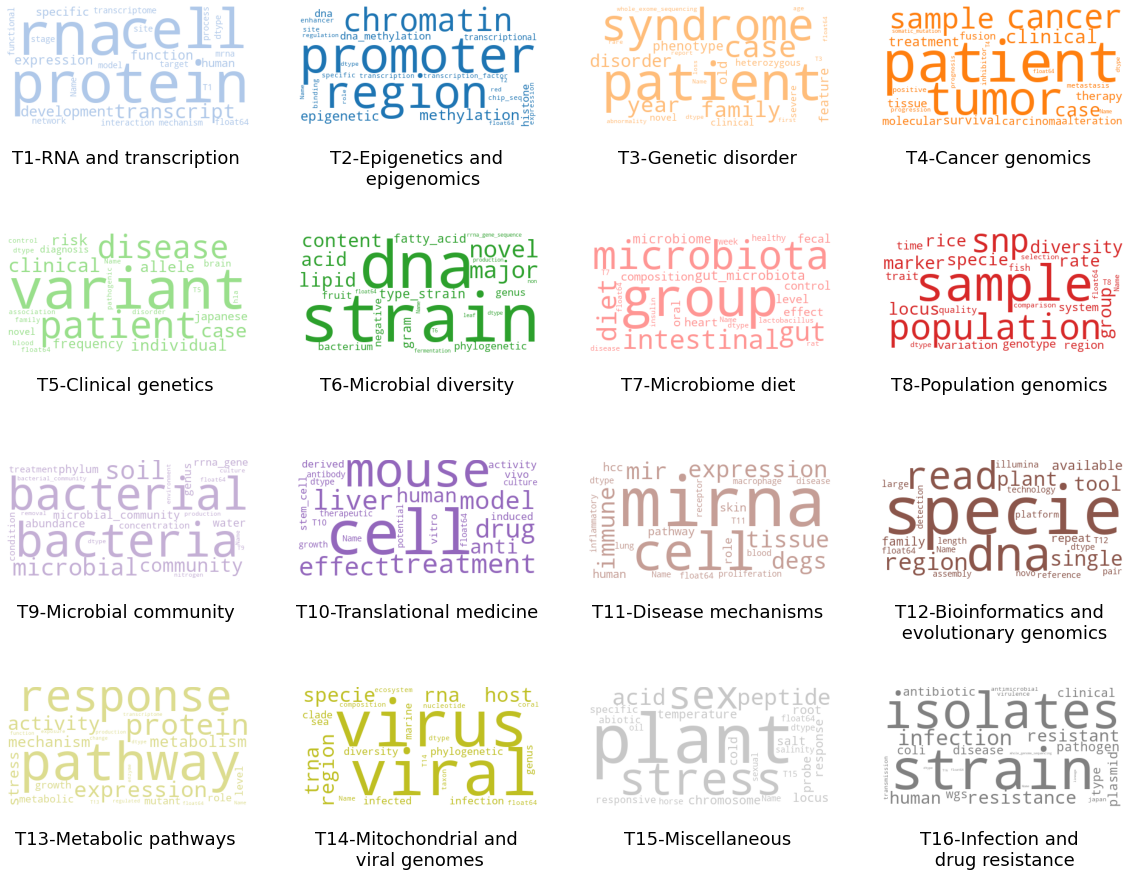

In [23]:
#combined

from collections import Counter
import wordcloud
from wordcloud import WordCloud, STOPWORDS

def color(i):
    def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
        return('hsl('+ i +')'.format(np.random.randint(49,51)))
    return grey_color_func

rows=4
cols=4

fig, ax = plt.subplots(rows, cols, figsize=(20, 16))

row=0 
col=0 

color_map = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'copper', 'pink_r', 'Greys',
             'Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'copper', 'pink_r', 'Greys']
cols = K

topic_name = ['T1-RNA and transcription \n ', 'T2-Epigenetics and \n epigenomics', 'T3-Genetic disorder \n ', 'T4-Cancer genomics \n ', 
                'T5-Clinical genetics \n ', 'T6-Microbial diversity \n ', 'T7-Microbiome diet \n ', 'T8-Population genomics \n ', 
                'T9-Microbial community \n ', 'T10-Translational medicine \n ', 'T11-Disease mechanisms \n ', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-Metabolic pathways \n ', 'T14-Mitochondrial and \n viral genomes ', 'T15-Miscellaneous \n ', 'T16-Infection and \n drug resistance']

for t,c,n in zip(cols, hsl_color, topic_name) :
    dtemp = word_topic_df[[t]].sort_values(by = [t], ascending =False).head(20)
    text = dtemp[t]
    wordcloud = WordCloud(background_color='white', color_func = color(c), random_state = 2).generate(str(text))
#    wordcloud.recolor(color_func = color(c))
    ax[col][row].imshow(wordcloud)
    ax[col][row].axis("off")
    ax[col][row].set_title(n, y=-0.35,pad=-14, size = 18)
    row=row+1
    if row==rows:
        row=0
        col=col+1


plt.savefig('fig/lda_n/wcall.png', bbox_inches='tight')
plt.show() 

In [ ]:
#Individual 

from collections import Counter
import wordcloud
from wordcloud import WordCloud, STOPWORDS

color_map = ['Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'copper', 'pink_r', 'Greys',
             'Blues', 'Oranges', 'Greens', 'Reds', 'Purples', 'copper', 'pink_r', 'Greys']
cols = K

for t,c in zip(cols,color_map) :
    dtemp = word_topic_df[[t]].sort_values(by = [t], ascending =False).head(20)
    text = dtemp[t]

    wordcloud = WordCloud(background_color='white', colormap = c, random_state = 2).generate(str(text))

    plt.imshow(wordcloud)
    plt.axis("off")
#    plt.savefig('fig/lda/wc2'+str(t)+'.png', dpi=dpi)
    plt.show()
    #'gist_earth'

In [80]:
# tabel worldclod

tcode = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Population genomics', 
                'T9-Microbial community', 'T10-Translational medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

fword = []
for t in K :
    dtemp = word_topic_df[[t]].sort_values(by = [t], ascending =False).head(15)
    text = dtemp.index.tolist()
    fword.append(text)

vpropo = [f/len(doc_topic_df)*100 for f in doc_topic_df.sum()]

tabel_wc = pd.DataFrame({'No': K, 'Topic Name' : tcodes, 'Frequent Words' : fword, 'Propotion': vpropo})
tabel_wc.to_excel('fig/lda_n/tabelwc.xlsx', index=False)

## Topic trends

In [327]:
#Get yearly data

year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
dt_df = doc_topic_df[K]
dt_df['Year'] = md['Year'].tolist()
tpl = {}
for t in K :
    dd = dt_df[[t, 'Year']]
    dd.columns = [t, 'Year']
    yl = []
    for y in year:
        pop = dd.loc[dd['Year'] == int(y), t].sum()
        yl.append(pop)
    tpl[t] = yl

### Topic proportion

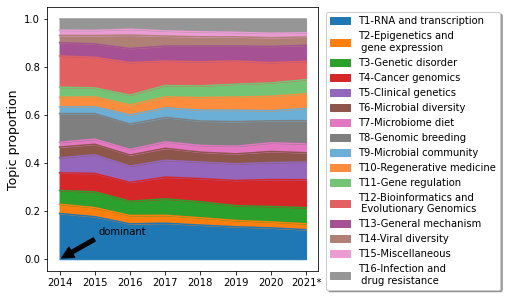

In [320]:
sns.reset_orig()
#sns.set_theme(color_codes=True)

dtp = pd.DataFrame([tpl[K[0]], tpl[K[1]],tpl[K[2]],tpl[K[3]],tpl[K[4]],
                   tpl[K[5]], tpl[K[6]], tpl[K[7]], tpl[K[8]], tpl[K[9]], 
                    tpl[K[10]], tpl[K[11]], tpl[K[12]], tpl[K[13]], tpl[K[14]], tpl[K[15]]], columns = year)
tcode = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Population genomics', 
                'T9-Microbial community', 'T10-Translational medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

color = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', 
        '#6BAED6', '#FD8D3C', '#74C476', '#E26060', '#A55194', '#AF8076', '#EB9CD4', '#969696']

color_old = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey', 
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:grey']

dtp.columns = ['2014', '2015', '2016', '2017' ,'2018', '2019', '2020', '2021*']
dtp = dtp.transpose()
#dtp.columns = tcode
dtp.columns = K
dtpn = dtp.div(dtp.sum(axis=1), axis=0)

#dtp.columns = K
#dtpn.plot.area(stacked=True, color=color, legend='reverse', figsize = (6,4))
#plt.legend(loc='upper center', bbox_to_anchor=(1.1,1), shadow=True, ncol=1)

dtpn.columns = tcode
dtpn.plot.area(stacked=True, color=color, legend='reverse', figsize = (8,4.5))
#plt.legend(loc='upper center', bbox_to_anchor=(1.3,1), shadow=True, ncol=1)

plt.ylabel('Topic proportion', size = 12.5)
plt.legend(loc='upper center', bbox_to_anchor=(1.35,1), shadow=True, ncol=1)
#plt.gca().invert_xaxis()

plt.annotate('dominant', xy=(0, 0), xytext=(1.1, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

plt.tight_layout()
#plt.savefig('fig/lda/plncomln.png', dpi=dpi)

In [342]:
ptg = [f/sum(dtp.sum().tolist()) for f in dtp.sum().tolist()]
ddptg = {ptg[i]: K[i] for i in range(len(K))}
t_dom = [ddptg[f] for f in ptg if  (f >= 0.1)]


['T1', 'T8', 'T12']

### Topic prevalence

In [84]:
#determine trends (positive or negative) with correlation coefficient

dtpn.columns = K
dtpnt = dtpn.transpose().drop(columns= ['2021*'])
dtpnp = dtpnt.transpose()

import scipy 
from scipy.stats import pearsonr
import math

corr_sco = []
for c in K: 
    x = np.array(list(range(1,8)))
    y = dtpnp[c].head(7).tolist()
    corr, _ = pearsonr(x, y)
    corr_sco.append(corr)

corr_sco = [round(f, 2) for f in corr_sco]
dtpnt['corr_sco'] = corr_sco

In [145]:
#determine trends (positive or negative) with linear regression

dtpn.columns = K
dtpnt = dtpn.transpose().drop(columns= ['2021*'])
dtpnp = dtpnt.transpose()

import scipy 
from scipy.stats import linregress
import math

linrv_sco = []
linpv_sco = []
for c in K: 
    x = np.array(list(range(1,8)))
    y = dtpnp[c].head(7).tolist()
    _, _, r, p, _ = linregress(x, y)
    linrv_sco.append(r)
    linpv_sco.append(p)

linrv_sco = [round(f, 3) for f in linrv_sco]
linpv_sco = [round(f, 3) for f in linpv_sco]

dtpnt['linrv_sco'] = linrv_sco
dtpnt['linpv_sco'] = linpv_sco

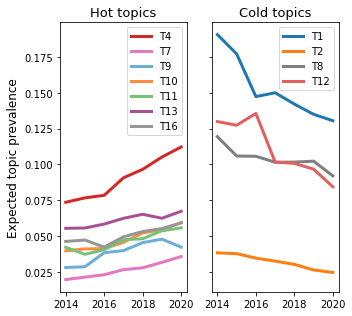

In [347]:
#Create plot original

#dtpnt['color'] = color
dtpntp = dtpnt[(dtpnt['linpv_sco'] < 0.05) & (dtpnt['linrv_sco'] > 0)].drop(columns= ['linrv_sco', 'linpv_sco']).transpose()
dtpntn = dtpnt[(dtpnt['linpv_sco'] < 0.05) & (dtpnt['linrv_sco'] < 0)].drop(columns= ['linrv_sco', 'linpv_sco']).transpose()

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(5,4.5))

pcolor = [ddcolor[b] for b in list(dtpntp.columns)]
dtpntp.plot(ax=ax1, linewidth=3.0, color = pcolor)
ax1.set_title('Hot topics', size =13)
ax1.set_ylabel('Expected topic prevalence', size =12)

ncolor = [ddcolor[b] for b in list(dtpntn.columns)]
dtpntn.plot(ax=ax2, linewidth=3.0, color = ncolor)
ax2.set_title('Cold topics', size =13)

#sns.reset_orig()
plt.tight_layout()
plt.savefig('fig/lda/hctopcom.png', dpi=dpi)

In [251]:
dtpntp

,T4,T7,T9,T10,T11,T13,T16
2014,0.073653,0.019788,0.028195,0.039818,0.042289,0.055496,0.046360
2015,0.076715,0.021467,0.028714,0.041158,0.037354,0.055717,0.047323
2016,0.078492,0.023153,0.038492,0.041375,0.040640,0.058446,0.042390
2017,0.090689,0.026694,0.039933,0.045716,0.047536,0.062461,0.049581
2018,0.096619,0.027974,0.045535,0.052364,0.048250,0.065270,0.053254
2019,0.105161,0.031757,0.047947,0.054323,0.053754,0.062505,0.055314
2020,0.112192,0.035832,0.042390,0.059490,0.055817,0.067365,0.059274


### Linear regression

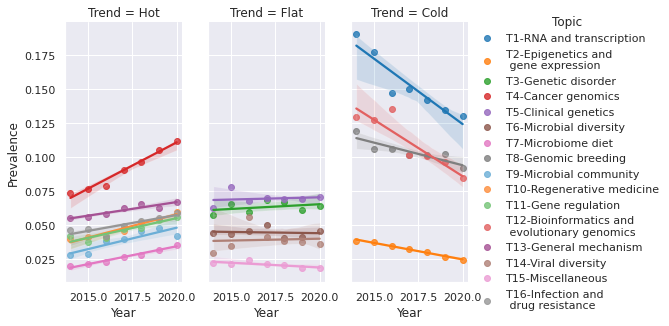

In [213]:
#Create plot with linear regression

df = dtpnt
tname = ['Hot' if ((rv > 0) & (pv < 0.05)) else 'Cold' if ((rv < 0) & (pv < 0.05)) else 'Flat' for rv,pv in zip(df['linrv_sco'], df['linpv_sco'])]
df = df.drop(columns = ['linrv_sco', 'linpv_sco']).transpose()
tcode = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Population genomics', 
                'T9-Microbial community', 'T10-Translational medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']
df.columns = tcode
cname = df.columns.tolist()
iname = df.index.tolist()
prev = [df[t].tolist() for t in cname]
prev = [item for sublist in prev for item in sublist]
top = [[y] * len(iname) for y in cname]
top = [item for sublist in top for item in sublist]
yea = [iname * len(cname)]
yea = [item for sublist in yea for item in sublist]
yea = [float(y) for y in yea]
tre = [[y] * len(iname) for y in tname]
tre = [item for sublist in tre for item in sublist]

col_order = ['Hot', 'Flat', 'Cold']
dfml = pd.DataFrame({'Topic': top, 'Year': yea, 'Prevalence': prev, 'Trend': tre})
#dfml = dfml.sort_values(by = 'Trend', ascending = False)

#sns.reset_orig()
sns.set_theme(color_codes=True)
sns.lmplot(data=dfml, x='Year', y='Prevalence', hue='Topic', col='Trend', 
           palette = color, height=4.7, aspect=.5, col_order = col_order)
#plt.savefig('fig/lda/hclmtopcoms3l.png', dpi=dpi)

In [214]:
# Transform data
def lmplot_trf(df = ''):
    tname = ['Hot' if ((rv > 0) & (pv < 0.05)) else 'Cold' if ((rv < 0) & (pv < 0.05)) else 'Flat' for rv,pv in zip(df['linrv_sco'], df['linpv_sco'])]
    df = df.drop(columns = ['linrv_sco', 'linpv_sco']).transpose()

    tcode = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Population genomics', 
                'T9-Microbial community', 'T10-Translational medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

#    df.columns = tcode
    df.columns = K
    cname = df.columns.tolist()
    iname = df.index.tolist()
    prev = [df[t].tolist() for t in cname]
    prev = [item for sublist in prev for item in sublist]
    top = [[y] * len(iname) for y in cname]
    top = [item for sublist in top for item in sublist]
    yea = [iname * len(cname)]
    yea = [item for sublist in yea for item in sublist]
    yea = [float(y) for y in yea]
    tre = [[y] * len(iname) for y in tname]
    tre = [item for sublist in tre for item in sublist]
    
    dfml = pd.DataFrame({'Topic': top, 'Year': yea, 'Prevalence': prev, 'Trend': tre})
#    dfml = dfml.sort_values(by = 'Trend', ascending = False)
    return dfml

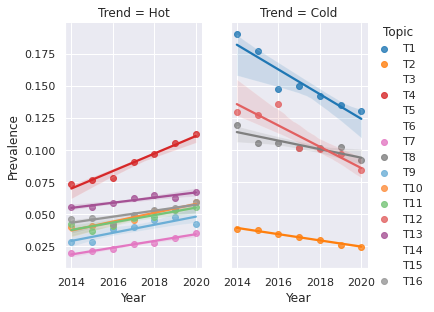

In [229]:
#Create plot expected (multiple linear regression)

lmd = lmplot_trf(dtpnt)

col_order = ['Hot', 'Cold']
sns.lmplot(data=lmd, x='Year', y='Prevalence', hue='Topic', col='Trend', 
           palette = color, height=4.5, aspect=.6, col_order = col_order)

#sns.reset_orig()
sns.set_theme(color_codes=True)

#plt.tight_layout()
#plt.savefig('fig/lda/hclmtopcomls.png', dpi=dpi)

## Topic trends per country

In [279]:
# prepare data

idx = [all_idx, jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx, phi_idx]
code = 'ALL', 'JPN' , 'KOR', 'SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL'
clist = {}

for c,i in zip(code, idx): 
    doc_topic_dfc = pd.DataFrame(lda_ft[i], columns=[K])
    doc_topic_dfc['Year'] = md['Year'][i].tolist()
    
    tpl = {}
    for t in K :
        dd = doc_topic_dfc[[t, 'Year']]
        dd.columns = [t, 'Year']
        yl = []
        for y in year:
            pop = dd.loc[dd['Year'] == int(y), t].sum()
            yl.append(pop)
            tpl[t] = yl
    

    dtp = pd.DataFrame([tpl[K[0]], tpl[K[1]],tpl[K[2]],tpl[K[3]],tpl[K[4]],
                   tpl[K[5]], tpl[K[6]], tpl[K[7]], tpl[K[8]], tpl[K[9]], 
                    tpl[K[10]], tpl[K[11]], tpl[K[12]], tpl[K[13]], tpl[K[14]], tpl[K[15]]], columns = year)
    tcode = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16']
    
    dtp.columns = ['2014', '2015', '2016', '2017' ,'2018', '2019', '2020', '2021*']
    dtp = dtp.transpose()
    dtp.columns = tcode
    clist[c] = dtp.div(dtp.sum(axis=1), axis=0)    

### Topic proportion

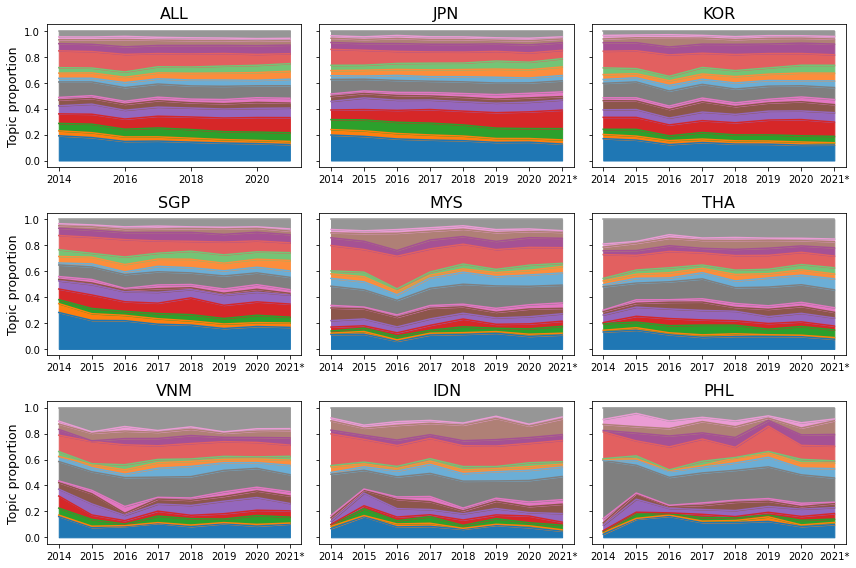

In [280]:
#Topic proportion

fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (12,8), sharey = True)
color = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', 
        '#6BAED6', '#FD8D3C', '#74C476', '#E26060', '#A55194', '#AF8076', '#EB9CD4', '#969696']

sns.reset_orig()
rows, row = 3, 0
cols, col = 3, 0
for d in clist.keys(): 
    clist[d].plot.area(ax = ax[col][row], stacked=True, color=color, legend=None)
    ax[col][row].set_ylabel('Topic proportion', size = 12.5)
    ax[col][row].set_title(d, size = 16)
    plt.tight_layout()
    row = row+1
    if row == rows:
        row = 0
        col = col+1
plt.tight_layout()
#plt.savefig('fig/lda/plncountry.png', dpi=dpi)
plt.show()

### Topic prevalence

In [38]:
#determine trends (positive or negative) with pearson

import scipy 
from scipy.stats import pearsonr
import math

cplist = {}
for d in code: 
    dtpnt = clist[d].transpose().drop(columns= ['2021*'])
    dtpnp = dtpnt.transpose()
    
    corr_sco = []
    for c in K: 
        x = np.array(list(range(1,8)))
        y = dtpnp[c].head(7).tolist()
        corr, _ = pearsonr(x, y)
        corr_sco.append(corr)

    corr_sco = [round(f, 2) for f in corr_sco]
    dtpnt['corr_sco'] = corr_sco
    cplist[d] = dtpnt

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [ ]:
#Create plot per trends

cllist = {}
for d in code: 
    cllist[d] = lmplot_trf(cplist[d])

In [ ]:
#Plot two trends

clct = [cllist[c] for c in code]
cdl = [[c] * 112 for c in code ]
cdl = [item for sublist in cdl for item in sublist]
dfcl = pd.concat(clct, axis=0)
dfcl['Country'] = cdl
dpos = dfcl.loc[dfcl['Trend'] != 'Negative', :].sort_values(by = ['Topic'])
dneg = dfcl.loc[dfcl['Trend'] == 'Negative', :].sort_values(by = ['Topic'])

trend = ['Positive trend', 'Negative trend']
dtre = dpos, dneg

#sns.reset_orig()
sns.set_theme(color_codes=True)

for c,d in zip(trend, dtre):
    sns.lmplot(data=d, x='Year', y='Prevalence', hue='Topic', col='Country', 
           palette = color, height=5, aspect=.5, col_order = code, hue_order=K, legend_out = True)
    plt.show()
 #   plt.savefig('fig/lda/hclmtop'+ c +'.png', dpi=dpi)


In [39]:
#determine trends (positive or negative) with linear regression

import scipy 
from scipy.stats import linregress
import math

cplist = {}
for d in code: 
    dtpnt = clist[d].transpose().drop(columns= ['2021*'])
    dtpnp = dtpnt.transpose()
    
    lr_sco = []
    for c in K: 
        x = np.array(list(range(1,8)))
        y = dtpnp[c].head(7).tolist()
        slope, intercept, r_value, p_value, std_err  = linregress(x, y)
        lr_sco.append(r_value)

    corr_sco = [round(f, 2) for f in lr_sco]
    dtpnt['lr_sco'] = lr_sco
    cplist[d] = dtpnt

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


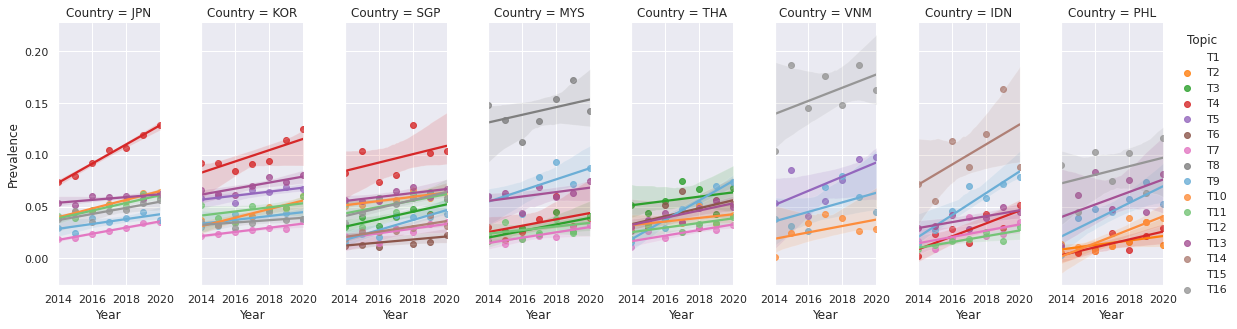

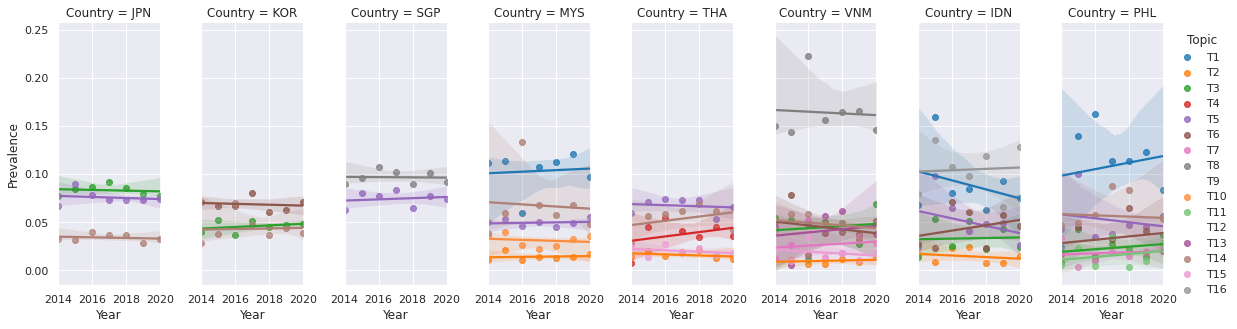

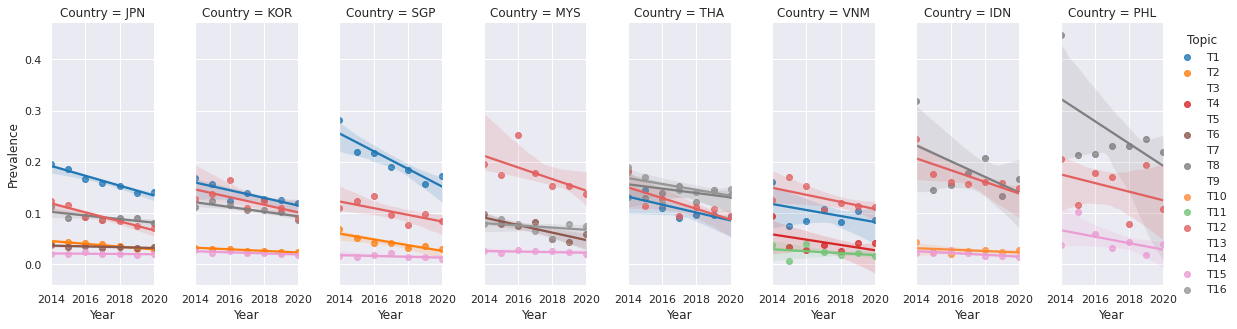

In [46]:
#Plot 3 trends

cllist = {}
for d in code: 
    cllist[d] = lmplot_trf(cplist[d])

clct = [cllist[c] for c in code]
cdl = [[c] * 112 for c in code ]
cdl = [item for sublist in cdl for item in sublist]
dfcl = pd.concat(clct, axis=0)
dfcl['Country'] = cdl
dpos = dfcl.loc[dfcl['Trend'] == 'Positive', :].sort_values(by = ['Topic'])
dneg = dfcl.loc[dfcl['Trend'] == 'Negative', :].sort_values(by = ['Topic'])
dsta = dfcl.loc[dfcl['Trend'] == 'Stable', :].sort_values(by = ['Topic'])

trend = ['Positive trend', 'Stable trend', 'Negative trend']
dtre = dpos, dsta, dneg

#sns.reset_orig()
sns.set_theme(color_codes=True)

for c,d in zip(trend, dtre):
    ax = sns.lmplot(data=d, x='Year', y='Prevalence', hue='Topic', col='Country', 
           palette = color, height=4.5, aspect=.45, col_order = code, hue_order=K, legend_out = True, sharey = True)
 #   ax.set(ylabel = c)
#    plt.show()
    plt.savefig('fig/lda/hclmtop3'+ c +'.png', dpi=dpi)

In [27]:
dtpnt

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,2014,2015,2016,2017,2018,2019,2020,corr_sco
T1,0.023845,0.139845,0.161939,0.113276,0.113938,0.122867,0.082979,0.17
T2,0.013759,0.006081,0.009378,0.011930,0.015733,0.035016,0.012565,0.50
T3,0.008236,0.042955,0.010519,0.027602,0.022286,0.013796,0.036201,0.22
T4,0.005357,0.004868,0.006557,0.024627,0.007980,0.021266,0.029446,0.79
T5,0.042760,0.100161,0.034932,0.037098,0.046718,0.045017,0.056279,-0.20
T6,0.017301,0.044395,0.014528,0.032540,0.064413,0.040746,0.019458,0.21
T7,0.033765,0.003544,0.009070,0.018456,0.015069,0.020312,0.026147,0.13
T8,0.448121,0.213998,0.215773,0.231205,0.230793,0.244411,0.218942,-0.56
T9,0.003286,0.038754,0.047110,0.044291,0.056869,0.073874,0.052343,0.81
T10,0.005168,0.010936,0.006767,0.011706,0.038768,0.034757,0.039071,0.89


/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


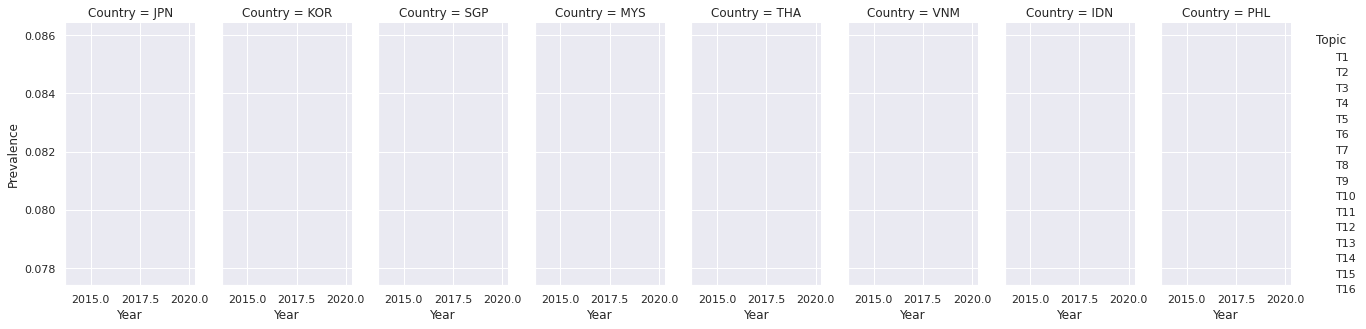

In [307]:
sns.lmplot(data=dneg, x='Year', y='Prevalence', hue='Topic', col='Country', 
           palette = color, height=4.5, aspect=.5, col_order = code, hue_order=K, legend_out = True)
plt.show()

In [ ]:
#Create plot per country

cllist = {}
for d in code: 
    cllist[d] = lmplot_trf(cplist[d])

col_order = ['Positive', 'Negative']
for d in code:
    sns.lmplot(data=cllist[d], x='Year', y='Prevalence', hue='Topic', col='Trend', 
           palette = color, height=4, aspect=.5, col_order = col_order).fig.suptitle(d, size = 16, y =1.03)
#    plt.savefig('fig/lda/hclmtop'+ d +'.png', dpi=dpi)

In [ ]:
#Create plot (prevalence originial)

for d in code:
    dtpnt = cplist[d]
    dtpntp = dtpnt[(dtpnt['corr_sco'] > 0)].drop(columns= ['corr_sco']).transpose()
    dtpntn = dtpnt[(dtpnt['corr_sco'] < 0)].drop(columns= ['corr_sco']).transpose()
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(6,6))
    
    dtpntp.plot(ax=ax1, linewidth=3.0)
    ax1.set_title('Hot topics', size =13)
    ax1.set_ylabel('Expected topic prevalence', size =12)
    
    dtpntn.plot(ax=ax2, linewidth=3.0)
    ax2.set_title('Cold topics', size =13)
    
    plt.tight_layout()
    plt.show()
#plt.savefig('fig/lda/hctopcom.png', dpi=dpi)

## Visualize pearson correlation

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


AttributeError: 'ClusterGrid' object has no attribute 'ax_clustermap'

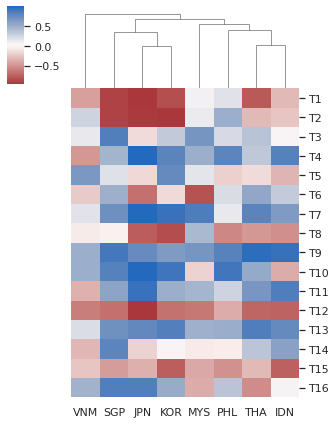

In [245]:
pclist = {}
for c in code:
    pclist[c] = cplist[c]['lr_sco'].tolist()
pcl = [pclist[c] for c in code]
pcd = pd.DataFrame(pcl)
pcd.columns = K
#pcd.columns = ['T1-RNA and transcription', 'T2-Epigenetics and gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
 #               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
  #              'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
   #             'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and drug resistance']

pcd = pcd.transpose()
pcd.columns = code

g = sns.clustermap(pcd, row_cluster=False, figsize=(4.75, 6), annot=False, cmap = 'vlag_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, size = 12)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0, size = 12)
#pcd.to_excel('fig/lda/pearson_score.xlsx')
#plt.savefig('fig/lda/cmtprel.png', dpi=dpi)

#7.2, 6, 4.75, 5.75

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


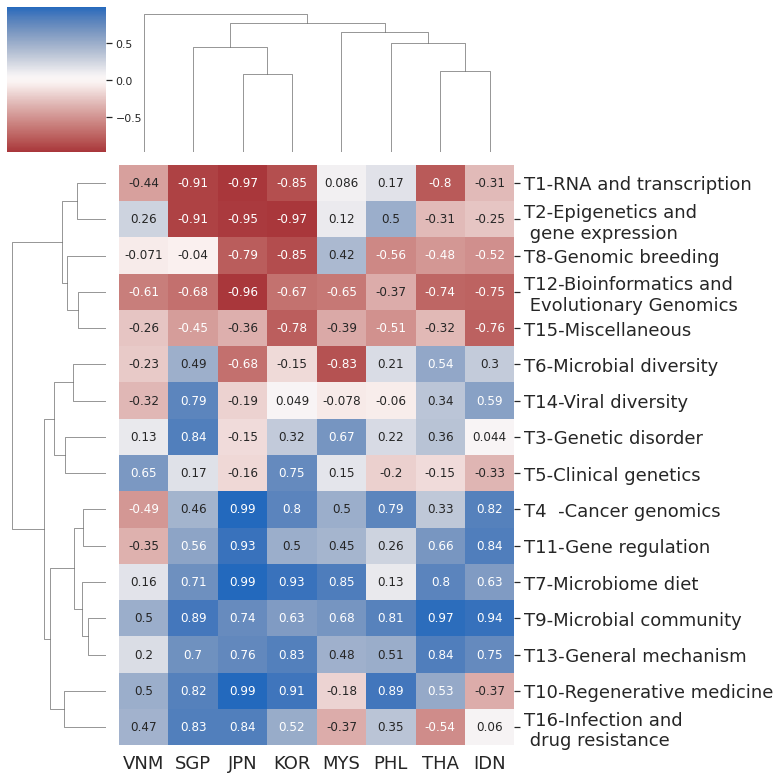

In [273]:
pclist = {}
for c in code:
    pclist[c] = cplist[c]['lr_sco'].tolist()
pcl = [pclist[c] for c in code]
pcd = pd.DataFrame(pcl)
pcd.columns = K
pcd.columns = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4  -Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
                'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

pcd = pcd.transpose()
pcd.columns = code

g = sns.clustermap(pcd, row_cluster=True, figsize=(11,11), annot=True, cmap = 'vlag_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, size = 18)  # For y axis
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0, size = 18)
plt.tight_layout()
#pcd.to_excel('fig/lda/pearson_score.xlsx')
plt.savefig('fig/lda/cmtpreln.png', dpi=dpi)

#7.2, 6, 4.75, 5.75

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


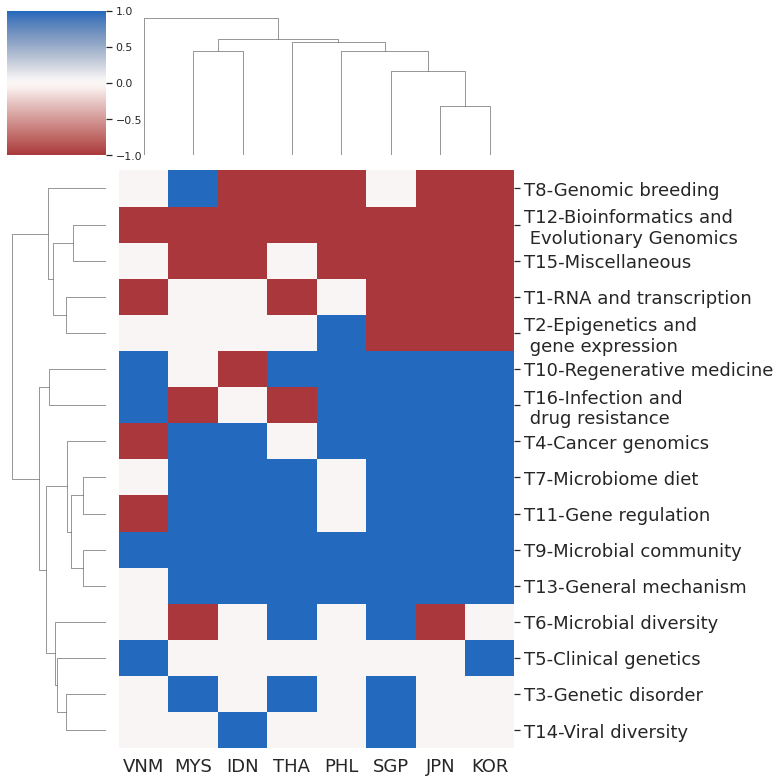

In [275]:
pcdd = {}
for c in code: 
    lf = pcd[c].tolist()
    lf = [1 if cs > 0.35 else -1 if cs < -0.35 else 0 for cs in lf]
    pcdd[c] = lf

pcddl = [pcdd[c] for c in code]
pcdf = pd.DataFrame(pcdd)
pcdf = pcdf.transpose()
pcdf.columns = tcode
pcdf.columns = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
              'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
              'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
             'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

pcdf = pcdf.transpose()
g = sns.clustermap(pcdf, row_cluster=True, figsize=(11,11), annot=False, cmap = 'vlag_r')
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, size = 18)  # For y axis
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0, size = 18)
plt.tight_layout()
plt.savefig('fig/lda/cmtprecn.png', dpi=dpi)

## Compare topic prevalence

In [184]:
idx = [jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx, phi_idx]
code = 'JPN' , 'KOR', 'SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL'
color = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', 
        '#6BAED6', '#FD8D3C', '#74C476', '#E26060', '#A55194', '#AF8076', '#EB9CD4', '#969696']


tplist = []
for i in idx :
    dfcp = doc_topic_df.loc[i, :].drop(columns= 'Year')
    dfcpl = dfcp.sum().tolist()
    dfcpln = [float(i)/sum(dfcpl) for i in dfcpl]
    tplist.append(dfcpln)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)
/home/nailil/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


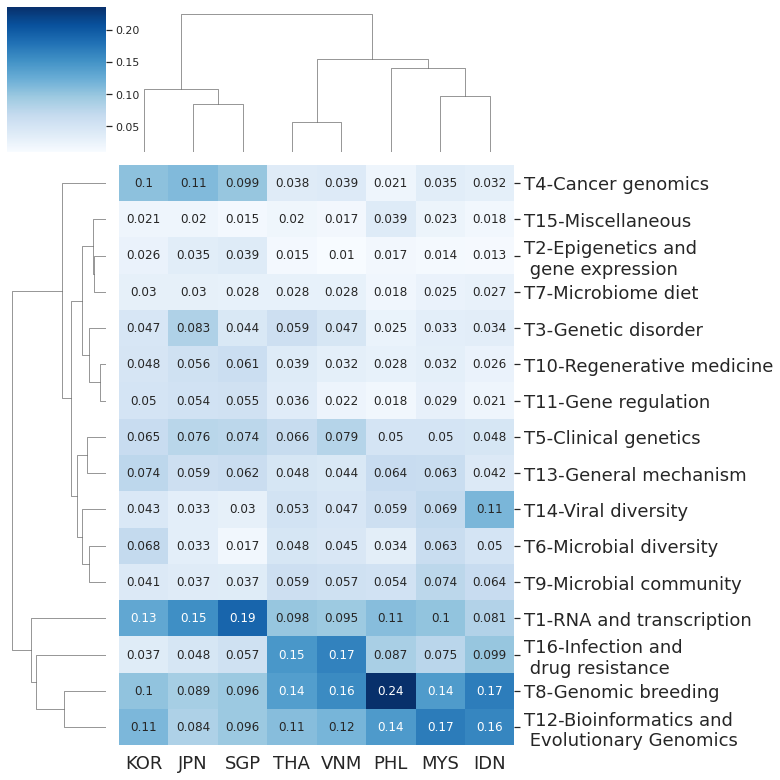

In [276]:
dftp = pd.DataFrame(tplist)
dftp.columns = K
dftp['code'] = code
dftp = dftp.set_index('code')
dftp.columns = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
                'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']
dftp = dftp.transpose()
dftp.columns.name = None

g = sns.clustermap(dftp, row_cluster=True, figsize=(11,11), annot=True, cmap = "Blues", )
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, size = 18)  # For y axis
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=0, size = 18)
plt.tight_layout()
#plt.tight_layout()
plt.savefig('fig/lda/cmtpopln.png', dpi=dpi)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


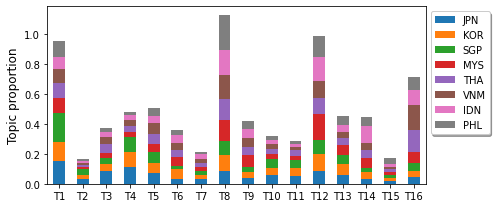

In [64]:
#stacked bar topic-country

color = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', 
        '#6BAED6', '#FD8D3C', '#74C476', '#E26060', '#A55194', '#AF8076', '#EB9CD4', '#969696']


dftp = pd.DataFrame(tplist)
dftp.columns = K
dftp['code'] = code
dftp = dftp.set_index('code')

dftp = dftp.transpose()
dftp.columns.name = None
dftp.plot.bar(stacked=True, color=color, legend='reverse', figsize = (7,3))
#plt.legend(loc='upper center', bbox_to_anchor=(1.3,1), shadow=True, ncol=1)

plt.ylabel('Topic proportion', size = 12)
plt.legend(loc='best', shadow=True, bbox_to_anchor=(1,1), ncol=1)
plt.xticks(rotation= 0)
#plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('fig/lda/tcbar1.png', dpi=dpi)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


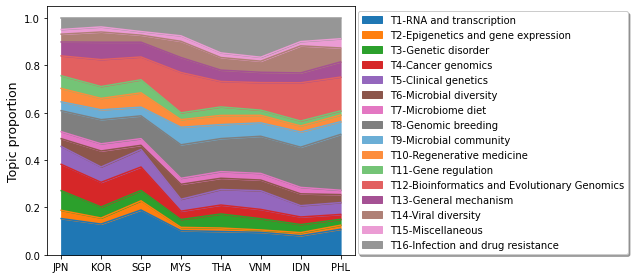

In [81]:
#stacked bar country-topic

color = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', 
        '#6BAED6', '#FD8D3C', '#74C476', '#E26060', '#A55194', '#AF8076', '#EB9CD4', '#969696']


dftp = pd.DataFrame(tplist)
dftp.columns = K
dftp['code'] = code
dftp = dftp.set_index('code')

dftp.columns = ['T1-RNA and transcription', 'T2-Epigenetics and gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
                'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and drug resistance']
dftp = dftp.transpose()
dftp.columns.name = None
dftp.transpose().plot.area(stacked=True, color=color, legend='reverse', figsize = (10.75,4.1))
#plt.legend(loc='upper center', bbox_to_anchor=(1.3,1), shadow=True, ncol=1)

plt.ylabel('Topic proportion', size = 12.5)
plt.legend(loc='upper center', bbox_to_anchor=(1.45,1), shadow=True, ncol=1)
plt.xticks(rotation= 0)
#plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('fig/lda/tcbar2.png', dpi=dpi)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning:

`run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



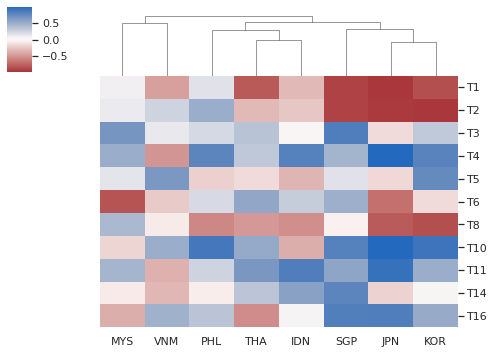

In [1210]:
#Topic comparison countries group
pcds = pcd[(pcd >= 0).all(axis=1) | (pcd < 0).all(axis=1)]
stl = pcds.index.tolist()
ttl = [f for f in K if f not in stl]
pcdt = pcd.loc[ttl, :]
sns.clustermap(pcdt, row_cluster=False, figsize=(7,5), annot=False, cmap = 'vlag_r')

## Visualize topic distribution with sankey

In [72]:
dfts

NameError: name 'dfts' is not defined

In [115]:
#Prepare data 

tslist = []
for i in idx :
    dfcs = doc_topic_df.loc[i, :]
    dfcsl = dfcs.sum().tolist()
    tslist.append(dfcsl)

dfts = pd.DataFrame(tslist)
dfts.columns = K
dfts['code'] = code
dfts = dfts.set_index('code')
dfts.columns = ['T1-RNA and transcription', 'T2-Epigenetics and gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
                'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and drug resistance']
dfts = dfts.transpose()
dfts.columns.name = None

ntopic = ['T1-RNA and transcription', 'T2-Epigenetics and gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
                'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and drug resistance']

dftsn = dfts.div(dfts.sum(axis=0), axis=1)
dfts.div(dfts.sum(axis=0), axis=1).to_excel('fig/lda_n/sankey_norm.xlsx')
dfts.to_excel('fig/lda_n/sankey_orig.xlsx')

In [1]:
code4

NameError: name 'code4' is not defined

In [102]:
# Transform to sankey format
def sankey_trf(df =''):
    sfreq = [df[c] for c in code]
    sfreq = [item for sublist in sfreq for item in sublist]
    scountry = [[c] * len(K) for c in code]
    scountry = [item for sublist in scountry for item in sublist]
    stopic = ntopic * len(code)
    dfs = pd.DataFrame({'country' : scountry, 'topic' : stopic, 'freq' : sfreq})
    return dfs

In [130]:
from webcolors import hex_to_rgb

data = sankey_trf(dfts)
#data = sankey_trf(dftsn)

sccode = list(data['country'].unique())
stcode = list(data['topic'].unique())

node_label = sccode + stcode
node_dict = {y:x for x, y in enumerate(node_label)}

source = data['country'].tolist()
target = data['topic'].tolist()
values = data['freq'].tolist()

source_node = [node_dict[x] for x in source]
target_node = [node_dict[x] for x in target]

In [131]:
#node_label
node_color = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#BCBD22', '#7F7F7F',
          '#AEC7E8', '#1F77B4', '#FFBB78', '#FF7F0E', 
           '#98DF8A', '#2CA02C', '#FF9896', '#D62728',
           '#C5B0D5', '#9467BD', '#C49C94', '#8C564B', 
           '#DBDB8D', '#BCBD22', '#C7C7C7', '#7F7F7F']

node_label_color = {x:y for x, y in zip(node_label, node_color)}
link_color = [node_label_color[x] for x in source]

link_color = ['rgba({},{},{}, 0.4)'.format(
    hex_to_rgb(x)[0],
    hex_to_rgb(x)[1],
    hex_to_rgb(x)[2]) for x in link_color] 
#link_color

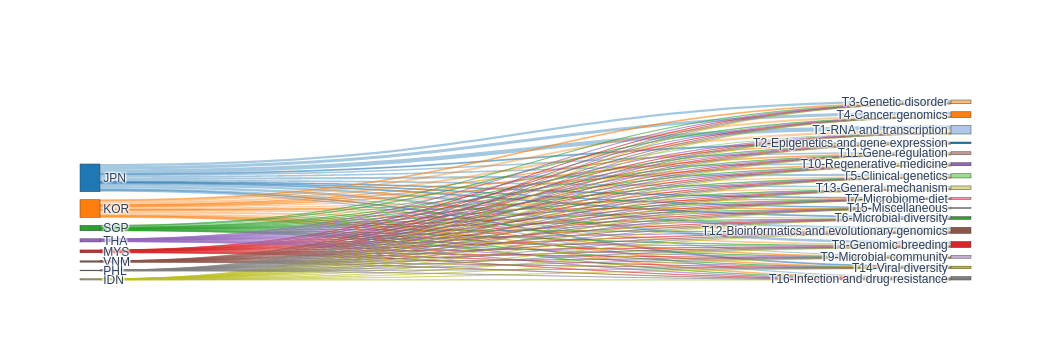

In [133]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go # Import the graphical object

fig = go.Figure( 
    data=[go.Sankey( # The plot we are interest
        # This part is for the node information
        node = dict( 
            label = node_label,
            color = node_color
        ),
        # This part is for the link information
        link = dict(
            source = source_node,
            target = target_node,
            value = values,
            color = link_color
                    ),
         arrangement = "snap")])

# With this save the plots 
plot(fig,
     image_filename='sankey_orig', 
#     image_filename='sankey_norm', 
     image='png', 
     image_width=600, 
     image_height=1000
)

# And shows the plot
fig.show()

## Cosine similarity

In [1237]:
csim.min() - 0.1

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0.680727567097208

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



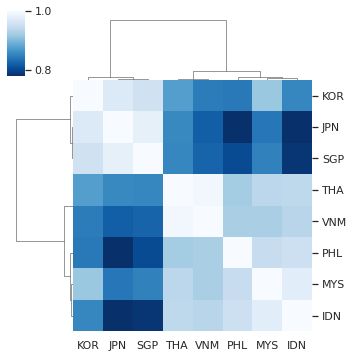

In [1243]:
from sklearn.metrics.pairwise import cosine_similarity

df = dftp.transpose()
csim = cosine_similarity(df, df)
#np.fill_diagonal(csim, csim.min())
csd = pd.DataFrame(csim, columns = code, index = code)

sns.clustermap(csd, figsize=(5,5), cmap='Blues_r', metric="correlation")
#plt.savefig('fig/lda/cmsc.png', dpi=dpi)

## Topic trends (increment) per country

In [380]:
idx = [jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx, phi_idx]
code = 'JPN' , 'KOR', 'SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL'

ttlist = []
for i in idx :
    dtc = doc_topic_df.loc[i, :]
    year = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
    tpl = {}
    for t in K :
        dd = dtc[[t, 'Year']]
        dd.columns = [t, 'Year']
        yl = []
        for y in year:
            pop = dd.loc[dd['Year'] == int(y), t].sum()
            yl.append(pop)
        tpl[t] = yl
        
    dtp = pd.DataFrame([tpl[K[0]], tpl[K[1]],tpl[K[2]],tpl[K[3]],tpl[K[4]],
                   tpl[K[5]], tpl[K[6]], tpl[K[7]], tpl[K[8]], tpl[K[9]], 
                    tpl[K[10]], tpl[K[11]], tpl[K[12]], tpl[K[13]], tpl[K[14]], tpl[K[15]]], columns = year)
    dtp = dtp.drop(columns ='2021')
    dtp = dtp.transpose()
    dtp.columns = K
    ttl = dtp.div(dtp.sum(axis=1), axis=0).pct_change().sum().tolist()
    ttlist.append(ttl)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [119]:
dftt = pd.DataFrame(ttlist)
dftt.columns = K
dftt['code'] = code
dftt = dftt.set_index('code')
dftt.columns = ['T1-RNA and gene transcription', 'T2-Epigenetics and gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
                'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
                'T9-Microbial community', 'T10-Drug efficacy', 'T11-Gene regulation', 'T12-Plant genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and drug resistance']

dftt = dftt.transpose()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(dftt,ax=ax)
plt.tight_layout()
#plt.savefig('fig/lda/cmttrnd.png', dpi=dpi)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'ttlist' is not defined

## Create dataframe representative topic 

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning:

`run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-32-5fbbaaf4cadb>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



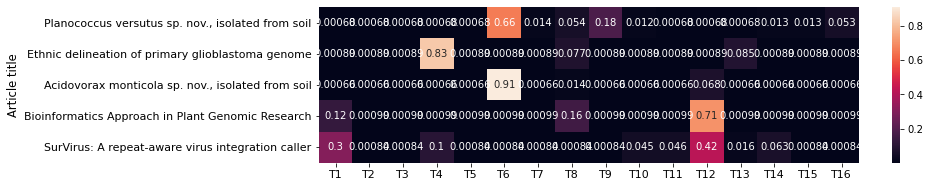

In [32]:
#Article

c = md[['Title', 'DOI']]
cl = [len(f) for f in c['Title'].tolist()]
c['len'] = cl
cs = c.sort_values(by = 'len')
cs = cs.head(250)
cs = cs.tail(5)
pub = cs.index.tolist()

tname = ['T1-RNA and transcription', 'T2-Epigenetics and \n gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
               'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Bioinformatics and \n evolutionary genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and \n drug resistance']

df = doc_topic_df.loc[pub]
df = df.drop(columns = 'Year')
#df.columns = tname
df.columns = K
nn = md.loc[pub, 'Title'].tolist()
df = df.transpose()
df.columns = nn
df = df.transpose()
#sns.clustermap(df, row_cluster=False, annot=True)


#fig, ax = plt.subplots(figsize=(14,4.5))
fig, ax = plt.subplots(figsize=(14,2.7))
sns.heatmap(df, annot=True)
plt.yticks(size=11); plt.xticks(size=11, rotation =0)
plt.ylabel('Article title', size=11.5)
plt.tight_layout()
#plt.savefig('fig/lda/tdrepl.png', dpi=dpi)

In [ ]:
#Word

c = md[['Title', 'DOI']]
cl = [len(f) for f in c['Title'].tolist()]
c['len'] = cl
cs = c.sort_values(by = 'len')
cs = cs.head(212)
cs = cs.tail(5)
pub = cs.index.tolist()

tname = ['T1-RNA and transcription', 'T2-Epigenetics and gene expression', 'T3-Genetic disorder', 'T4-Cancer genomics', 
               'T5-Clinical genetics', 'T6-Microbial diversity', 'T7-Microbiome diet', 'T8-Genomic breeding', 
               'T9-Microbial community', 'T10-Regenerative medicine', 'T11-Gene regulation', 'T12-Plant genomics', 
                'T13-General mechanism', 'T14-Viral diversity', 'T15-Miscellaneous', 'T16-Infection and drug resistance']


df = doc_topic_df.loc[pub]
df = df.drop(columns = 'Year')
df.columns = tname
nn = md.loc[pub, 'Title'].tolist()
df = df.transpose()
df.columns = nn
df = df.transpose()
#sns.clustermap(df, row_cluster=False, annot=True)


fig, ax = plt.subplots(figsize=(14,5))
sns.heatmap(df, annot=True)
plt.yticks(size=11); plt.xticks(size=11, rotation =90)
plt.ylabel('Article title', size=11.5)
plt.tight_layout()
#plt.savefig('fig/lda/tdrep.png', dpi=dpi)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



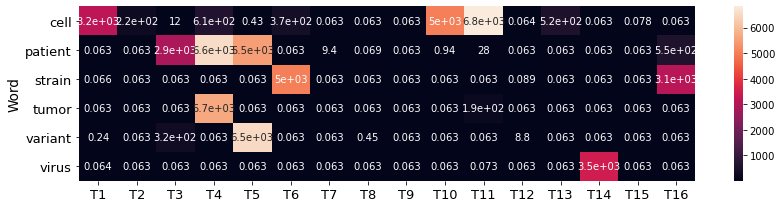

In [28]:
wn = ['cell', 'patient', 'strain', 'tumor', 'variant', 'virus']
df = word_topic_df.sort_values(by = 'T4', ascending = False)
df = df.loc[wn]
#df.columns = tname

fig, ax = plt.subplots(figsize=(12,3))
sns.heatmap(df, annot=True)
plt.yticks(size=13, rotation =0); plt.xticks(size=13, rotation = 0)
plt.ylabel('Word', size=13.5)
plt.tight_layout()
plt.savefig('fig/lda/twrep.png', dpi=dpi)

In [251]:
word_topic_df.sum(axis=1)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


01t         11.371189
07t          1.926461
08t          3.940776
0cyclo       3.389607
101g         2.295446
              ...    
zygosity     3.451449
zygote      57.794055
zygotic     67.803727
zymogram     2.627730
zymosan      2.414160
Length: 33554, dtype: float64

## Create datframe, title of max value in each cluster

In [189]:
cluster = np.argmax(lda_ft, axis=1) +1
cvalues = np.max(lda_ft, axis=1)

dfmv = pd.DataFrame([cluster, cvalues])
dfmv = dfmv.transpose()
dfmv.columns = ['cluster', 'values']
dfmv['title'] = md['Title'].tolist()
dfmv['CA'] = md['Clean Abstract'].tolist()

ccols = ['cluster','values', 'title']
cn = list(range(1,no_topics+1))
dmvt = {}
for k in cn:
    dmvt[k] = dfmv[dfmv['cluster'] == k].sort_values(by = 'values', ascending= False).head(25)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [191]:
dfmvt = pd.concat([dmvt[1], dmvt[2], dmvt[3], dmvt[4], dmvt[5], dmvt[6], dmvt[7], dmvt[8],
                  dmvt[9], dmvt[10], dmvt[11], dmvt[12], dmvt[13], dmvt[14], dmvt[15], dmvt[16]], axis=0)
dfmvt.to_csv('fig/lda/cvmaxtitle.csv')

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [272]:
df = dfmv[dfmv['cluster'] == 'T12'].sort_values(by = 'values', ascending= False).head(25)
dmvt[12]

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,cluster,values,title,CA
18730,12.0,0.953125,The complete chloroplast genome of Aconitum pu...,chloroplast_genome_sequence aconitum puchonroe...
3324,12.0,0.942314,Characterization of the complete chloroplast g...,complete_chloroplast_genome_sequence koelreute...
3411,12.0,0.939572,Chloroplast genome sequence of the hybrid vari...,complete_chloroplast_genome zantedeschia spp f...
1087,12.0,0.922488,A tool for analyzing evolutionary trees of rec...,genomic evolution next_generation_sequencing s...
18775,12.0,0.917492,The complete chloroplast genome sequence of Cy...,cynanchum auriculatum vine belonging apocynace...
...,...,...,...,...
638,12.0,0.772698,A near-chromosome-scale genome assembly of the...,abstract gemsbok oryx gazella antelope africa ...
8226,12.0,0.771591,Faster single-end alignment generation utilizi...,next_generation_sequencing technology genome s...
8221,12.0,0.771016,Fast and sensitive mapping of nanopore sequenc...,democratic promise nanopore sequencing develop...
14363,12.0,0.770770,Next generation sequencing reveals the complet...,complete_chloroplast_genome_sequence cliff dwe...


## Topic clustering

In [631]:
#topic_word_matrix[1]
dwt = {}
for k in K:
    dwt[k] = word_topic_df.sort_values(k, ascending=False).head(10)

fwt = [dwt[n] for n in K]   
dfwt = pd.concat(fwt, axis=0)
dfwt = dfwt.drop_duplicates()

sns.clustermap(dfwt, row_cluster=False)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [52]:
cluster = np.argmax(lda_ft, axis=1) +1
cvalues = np.max(lda_ft, axis=1)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Document Clustering

In [ ]:
import seaborn as sns; sns.set_theme(color_codes=True)

sns_plot = sns.clustermap(lda_ft[idn_idx], row_cluster=True)
#sns_plot.savefig('fig/lda/snscluster.png', dpi=dpi)

In [607]:
#safe cluster based on max value

cluster = np.argmax(lda_ft, axis=1) +1

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Prepare input for sankey diaghram

In [166]:
code = 'JPN' , 'KOR', 'SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL'
idx = jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx,  phi_idx
year = '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014'
cnum = list(range(1,no_topics +1))
scols = code + year

sdf = md.loc[:, scols]
sdf['cluster'] = cluster

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
#sdf.to_csv('fig/lda/clusterdata.csv')
sdf

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,JPN,KOR,SGP,MYS,THA,VNM,IDN,PHL,2021,2020,2019,2018,2017,2016,2015,2014,cluster
0,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,2
1,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,1
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,1
3,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,8
4,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21303,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,16
21304,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,13
21305,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,4
21306,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,1


In [35]:
freq = []
for c, i in zip(code, idx) :
    cdf = sdf.loc[sdf[c], (year)]
    cdf['cluster'] = cluster[i]
    for l in cnum:
        ldf = cdf.loc[cdf['cluster'] == l]
        for y in year :
            ydf = ldf.loc[(ldf[y])]
            lf = len(ydf)
            freq.append(lf)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
coulist = [[c] * (len(cnum)*len(year)) for c in code]
coulist = [item for sublist in coulist for item in sublist]

clulist = [[c] * len(code) for c in cnum]
clulist = [item for sublist in clulist for item in sublist]
clulist = [clulist] * len(year)
clulist = [item for sublist in clulist for item in sublist]

yealist = [year] * (len(code)*len(cnum))
yealist = [item for sublist in yealist for item in sublist]

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [37]:
fwdata8y = pd.DataFrame({'country' : coulist,
                   'cluster' : clulist,
                   'year' : yealist, 
                   'freq' : freq})
fwdata8y.to_csv('fig/lda/fwdata8y.csv', index= False)
fwdata8y.tail(10)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,country,cluster,year,freq
1014,PHL,15,2015,3
1015,PHL,15,2014,0
1016,PHL,16,2021,4
1017,PHL,16,2020,7
1018,PHL,16,2019,3
1019,PHL,16,2018,2
1020,PHL,16,2017,3
1021,PHL,16,2016,3
1022,PHL,16,2015,1
1023,PHL,16,2014,2


In [599]:
code = 'JPN' , 'KOR', 'SGP', 'MYS', 'THA', 'VNM', 'IDN', 'PHL'
idx = jpn_idx, kor_idx, sig_idx, mal_idx, tha_idx, vie_idx, idn_idx,  phi_idx
y_1 = '2020', '2018', '2016', '2014'
y_2 = '2021', '2019', '2017', '2015'
cnum = list(range(1,no_topics +1))
cluster = sdf['cluster'].tolist()

freq2 = []
for c, i in zip(code, idx) :
    cdf = sdf.loc[sdf[c], (year)]
    cdf['cluster'] = sdf['cluster'][i]
    for l in cnum:
        ldf = cdf.loc[cdf['cluster'] == l]
        for y1,y2 in zip(y_1, y_2) :
            ydf = ldf[ldf[y1] | ldf[y2]]
            lf = len(ydf)
            freq2.append(lf)

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [600]:
year2 = '2020-2021', '2018-2019', '2016-2017', '2014-2015' 

coulist2 = [[c] * (len(cnum)*len(year2)) for c in code]
coulist2 = [item for sublist in coulist2 for item in sublist]

clulist2 = [[c] * len(year2) for c in cnum]
clulist2 = [item for sublist in clulist2 for item in sublist]
clulist2 = [clulist2] * len(code)
clulist2 = [item for sublist in clulist2 for item in sublist]

yealist2 = [year2] * (len(code)*len(cnum))
yealist2 = [item for sublist in yealist2 for item in sublist]

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/nailil/anaconda3/lib/python3.8/asyncio/events.py:81: DeprecationWarning: `run_cell_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  self._context.run(self._callback, *self._args)


In [601]:
fwdf4y = pd.DataFrame({'country' : coulist2,
                   'cluster' : clulist2,
                   'year' : yealist2, 
                   'freq' : freq2})

fwdf4y.to_csv('fig/lda/fwdata4y.csv')

/home/nailil/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
